In [104]:
import numpy as np
import pandas as pd

import yfinance as yf 
from datetime import datetime

from yahooquery import Ticker #replacement for yf
import yahoo_fin.stock_info as si 

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot

from math import sqrt
import random

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [105]:
# Acquiring Data
target = 'aapl';
start_date = '2022-03-30';
end_date = '2023-03-30';
interval = "1d";
df= yf.download(tickers=target, start = start_date, end = end_date, interval=interval, auto_adjust=False, prepost=False)

[*********************100%***********************]  1 of 1 completed


In [106]:
# LSTM network
# fix random seed for reproducibility
tf.random.set_seed(7);
# load the dataset
dataframe = df[['Open']];
dataset = dataframe.values;
dataset = dataset.astype('float32');
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1));
dataset = scaler.fit_transform(dataset);
# split into train and test sets
train, test = train_test_split(dataset, test_size=0.33, shuffle=False);
# reshape into X=t and Y=t+1
look_back = 1;
trainX = train[:-1*look_back] #delete rows on the bottom;
trainY = np.roll(train, -1*look_back, axis=None)[:-1*look_back];
testX = test[:-1*look_back];
testY = np.roll(test, -1*look_back, axis=None)[:-1*look_back];

In [107]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX_feature.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [108]:
# create and fit the LSTM network
model = Sequential();
model.add(LSTM(4, input_shape=(1, 1)));
model.add(Dense(1));
model.compile(loss='mean_squared_error', optimizer='adam');
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2);
# make predictions
trainPredict = model.predict(trainX);
testPredict = model.predict(testX);
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict);
trainY = scaler.inverse_transform(trainY);
testPredict = scaler.inverse_transform(testPredict);
testY = scaler.inverse_transform(testY);

Epoch 1/100
167/167 - 2s - loss: 0.1401 - 2s/epoch - 14ms/step
Epoch 2/100
167/167 - 0s - loss: 0.0366 - 331ms/epoch - 2ms/step
Epoch 3/100
167/167 - 0s - loss: 0.0223 - 318ms/epoch - 2ms/step
Epoch 4/100
167/167 - 0s - loss: 0.0192 - 332ms/epoch - 2ms/step
Epoch 5/100
167/167 - 0s - loss: 0.0167 - 318ms/epoch - 2ms/step
Epoch 6/100
167/167 - 0s - loss: 0.0141 - 334ms/epoch - 2ms/step
Epoch 7/100
167/167 - 0s - loss: 0.0118 - 318ms/epoch - 2ms/step
Epoch 8/100
167/167 - 0s - loss: 0.0096 - 319ms/epoch - 2ms/step
Epoch 9/100
167/167 - 0s - loss: 0.0078 - 315ms/epoch - 2ms/step
Epoch 10/100
167/167 - 0s - loss: 0.0063 - 345ms/epoch - 2ms/step
Epoch 11/100
167/167 - 0s - loss: 0.0053 - 322ms/epoch - 2ms/step
Epoch 12/100
167/167 - 0s - loss: 0.0046 - 315ms/epoch - 2ms/step
Epoch 13/100
167/167 - 0s - loss: 0.0043 - 318ms/epoch - 2ms/step
Epoch 14/100
167/167 - 0s - loss: 0.0041 - 334ms/epoch - 2ms/step
Epoch 15/100
167/167 - 0s - loss: 0.0041 - 322ms/epoch - 2ms/step
Epoch 16/100
167/167 

Train Score: 3.30 RMSE
Test Score: 2.73 RMSE


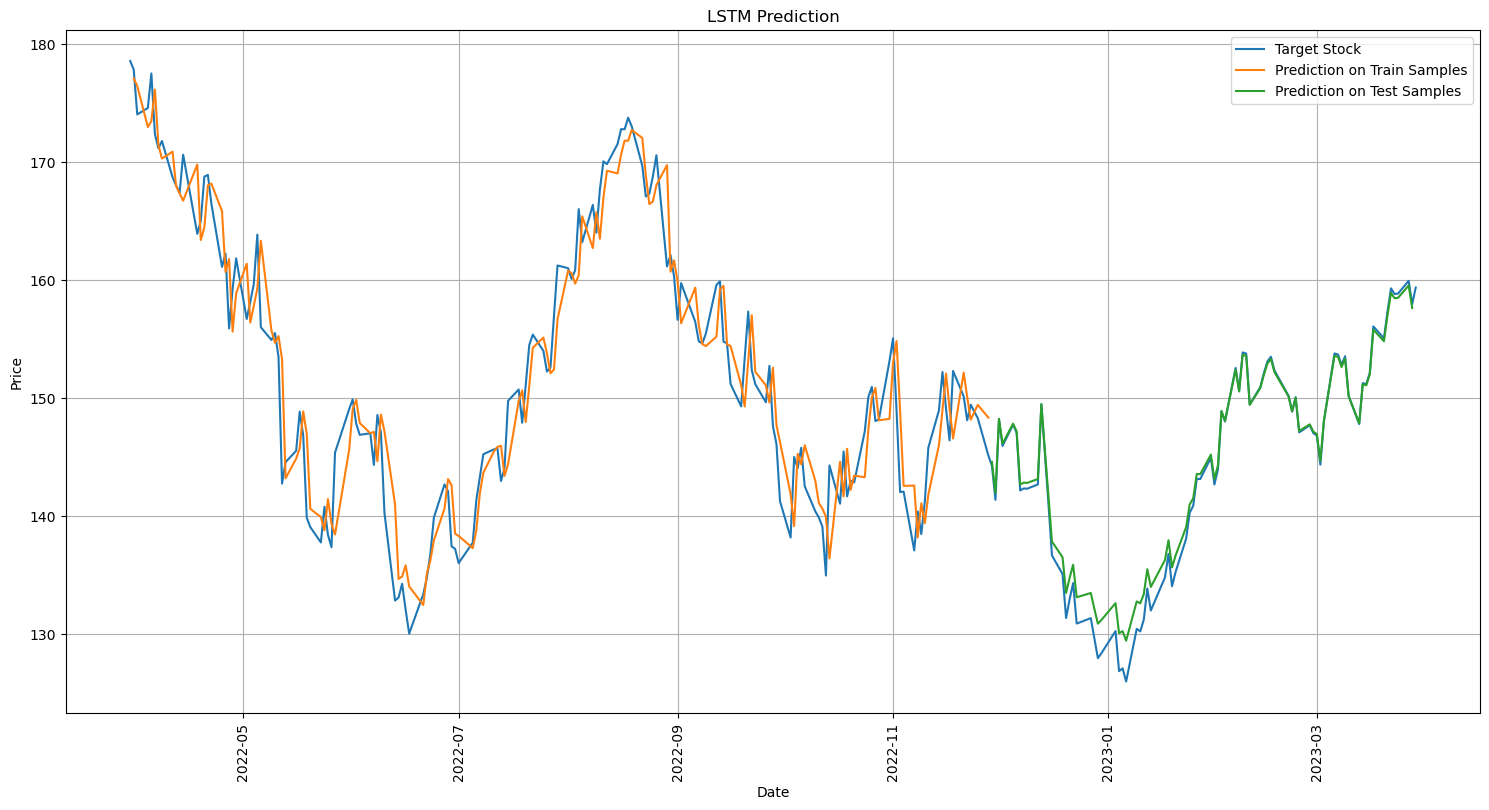

In [109]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict[:,0]));
print('Train Score: %.2f RMSE' % (trainScore));
testScore = np.sqrt(mean_squared_error(testY, testPredict[:,0]));
print('Test Score: %.2f RMSE' % (testScore));
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset);
trainPredictPlot[:, :] = np.nan;
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict;
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset);
testPredictPlot[:, :] = np.nan;
testPredictPlot[len(trainPredict)+look_back:len(dataset)-1, :] = testPredict;
# plot baseline and predictions
plt.figure(figsize=(15,8));
plt.plot(df.index.values, scaler.inverse_transform(dataset), label='Target Stock');
plt.plot(df.index.values, trainPredictPlot, label='Prediction on Train Samples');
plt.plot(df.index.values, testPredictPlot, label='Prediction on Test Samples');
plt.xlabel('Date');
plt.ylabel('Price');
plt.xticks(rotation=90);
plt.tight_layout();
plt.grid();
plt.title('LSTM Prediction');
plt.legend(loc='best');
plt.show();

In [110]:
# Multi-Feature LSTM network

In [172]:
# FEATURE EXTRACTION
df_feature = pd.DataFrame({});

In [173]:
# Open Price
df_feature.loc[:, 'Open'] = df['Open'];

# Index Ratio = (Today's volume)/(Previous day volume) * Previous day index ratio
df_feature.loc[:, 'Index Ratio'] = np.nan;
index_ir = df_feature.columns.get_loc('Index Ratio');
df_feature.iloc[0, index_ir] = 1000; #set the first ratio to be 1000
for i in range(1, len(df_feature)):
    ir = df['Volume'][i]/df['Volume'][i-1]*df_feature['Index Ratio'][i-1];
    df_feature.iloc[i, index_ir] = ir;

# P/E Ratio (extract data by yahoo_query)
# daily pe waste too much of time, so we use quarter data instead and use random mutipliers within the range to fulfill daily pe
df_feature.loc[:, 'PE'] = np.nan;
index_pe = df_feature.columns.get_loc('PE');
ticker = Ticker(target);
quarter = ticker.valuation_measures.loc[:, ['asOfDate','PeRatio']].reset_index(drop=True)
quarter = quarter.set_index('asOfDate')
list_quarter = quarter.loc['2022-03-31':'2023-03-23','PeRatio'].tolist(); #need to be adjusted if period changes
interval_average = int((len(df_feature)-1)/(len(list_quarter)-1)) #throw decimal
list_random = [];
for i in range(len(list_quarter)):
    list_random.append(list_quarter[i]);
    if i < len(list_quarter)-1:
        start = 1;
        end = round(list_quarter[i+1]/list_quarter[i],4);
        if list_quarter[i] > list_quarter[i+1]:
            list_interval = random.sample(range(int(end*10000), start*10000), interval_average-1);
            list_interval = [x/10000*list_quarter[i] for x in list_interval];
            list_interval = sorted(list_interval, reverse=True);
        else:
            list_interval = random.sample(range(start*10000, int(end*10000)), interval_average-1);
            list_interval = [x/10000*list_quarter[i] for x in list_interval];
            list_interval = sorted(list_interval, reverse=False);
        list_random.extend(list_interval);
    else: #the last interval, length is different from the former intervals'
        start = 0.995;
        end = 1.005;
        list_interval = random.sample(range(int(start*10000), int(end*10000)), len(df_feature)-(interval_average*(len(list_quarter)-1))-1);
        list_interval = [x/10000*list_quarter[i] for x in list_interval];
        list_interval = sorted(list_interval, reverse=True);
        list_random.extend(list_interval);
df_feature.loc[:, 'PE'] = list_random

# Simple Moving Average (SMA) 
SMA = df['Open'].expanding().mean();
df_feature.loc[:, 'SMA'] = SMA;

# On Balance Volume
df_feature.loc[:, 'OBV'] = np.nan;
index_obv = df_feature.columns.get_loc('OBV');
df_feature.iloc[0, index_obv] = df['Volume'][0]; #set the first OBV to be that day's volume
# take OBV into the iterations   
for i in range(1, len(df_feature)):
    if df['Close'][i] > df['Close'][i-1]:
        OBV = df_feature['OBV'][i-1] + df['Volume'][i];
    else:
        OBV = df_feature['OBV'][i-1] - df['Volume'][i];
    df_feature.iloc[i, index_obv] = OBV;

# Price Rate of Change(PROC) = (Today's close - close x period ago)/close x period ago * 100
# set the period to be x days
x = 1;
df_feature.loc[:, 'PROC - 5 days ago'] = np.nan;
index_proc = df_feature.columns.get_loc('PROC - 5 days ago');
for i in range(x,len(df_feature)):
    PROC = (df['Close'][i] - df['Close'][i-x])/(df['Close'][i-x])*100;
    df_feature.iloc[i,index_proc] = PROC;
    
# Close price -- trainy and testy
df_feature.loc[:, 'Close'] = df['Close'];

In [174]:
df_feature = df_feature.dropna(axis=0); #drop rows with NaN value
df_feature

,Open,Index Ratio,PE,SMA,OBV,PROC - 5 days ago,Close
Date,,,,,,,
2022-03-31,177.839996,1112.444566,28.788932,178.195000,-10416100.0,-1.777580,174.610001
2022-04-01,174.029999,850.141202,28.725227,176.806666,-89167400.0,-0.171813,174.309998
2022-04-04,174.570007,825.496690,28.690479,176.247501,-12699000.0,2.369345,178.440002
2022-04-05,177.500000,792.391929,28.626774,176.498001,-86100800.0,-1.894197,175.059998
2022-04-06,172.360001,961.413403,28.577547,175.808334,-175159600.0,-1.845079,171.830002
...,...,...,...,...,...,...,...
2023-03-23,158.830002,729.998532,21.310211,149.568381,107159100.0,0.696947,158.929993
2023-03-24,158.860001,639.041942,21.294221,149.605847,166355600.0,0.830559,160.250000
2023-03-27,159.940002,565.567205,21.275947,149.647350,113965300.0,-1.229330,158.279999


In [175]:
dataset_feature = df_feature.values;
dataset_feature = dataset_feature.astype('float32');
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1));
dataset_feature = scaler.fit_transform(dataset_feature);
# split into train and test sets
train_feature, test_feature = train_test_split(dataset_feature, test_size=0.33, shuffle=False);
# split into X,Y samples
trainX_feature, trainY_feature = train_feature[:, :-1], train_feature[:, -1];
testX_feature, testY_feature = test_feature[:, :-1], test_feature[:, -1];

In [177]:
# reshape input to be [samples, time steps, features]
trainX_feature = np.reshape(trainX_feature, (trainX_feature.shape[0], 1, trainX_feature.shape[1]))
testX_feature = np.reshape(testX_feature, (testX_feature.shape[0], 1, testX_feature.shape[1]))

In [178]:
# create and fit the LSTM network
model = Sequential();
model.add(LSTM(50, input_shape=(trainX_feature.shape[1], trainX_feature.shape[2])));
model.add(Dense(1)); # depend on trainY's shape[1]
model.compile(loss='mean_squared_error', optimizer='adam');
history = model.fit(trainX_feature, trainY_feature, epochs=100, batch_size=72, validation_data=(testX_feature, testY_feature), verbose=2, shuffle=False);

Epoch 1/100
3/3 - 3s - loss: 0.3095 - val_loss: 0.1561 - 3s/epoch - 1s/step
Epoch 2/100
3/3 - 0s - loss: 0.2821 - val_loss: 0.1415 - 62ms/epoch - 21ms/step
Epoch 3/100
3/3 - 0s - loss: 0.2564 - val_loss: 0.1277 - 62ms/epoch - 21ms/step
Epoch 4/100
3/3 - 0s - loss: 0.2321 - val_loss: 0.1147 - 72ms/epoch - 24ms/step
Epoch 5/100
3/3 - 0s - loss: 0.2092 - val_loss: 0.1025 - 64ms/epoch - 21ms/step
Epoch 6/100
3/3 - 0s - loss: 0.1875 - val_loss: 0.0912 - 67ms/epoch - 22ms/step
Epoch 7/100
3/3 - 0s - loss: 0.1672 - val_loss: 0.0807 - 66ms/epoch - 22ms/step
Epoch 8/100
3/3 - 0s - loss: 0.1481 - val_loss: 0.0710 - 68ms/epoch - 23ms/step
Epoch 9/100
3/3 - 0s - loss: 0.1304 - val_loss: 0.0621 - 66ms/epoch - 22ms/step
Epoch 10/100
3/3 - 0s - loss: 0.1141 - val_loss: 0.0542 - 66ms/epoch - 22ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0992 - val_loss: 0.0471 - 68ms/epoch - 23ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0858 - val_loss: 0.0409 - 71ms/epoch - 24ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0738 - va

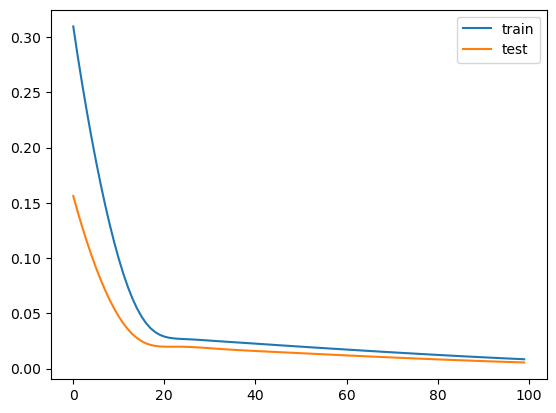

In [179]:
# plot history of mse in each epoch
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# Train loss drops quickly closing to test loss  
# The model may be overfitting the training data
# Measuring and plotting RMSE during training may shed more light on this

In [180]:
# make a prediction
yhat = model.predict(testX_feature)
testX_feature = testX_feature.reshape((testX_feature.shape[0], testX_feature.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_feature[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
testY_feature = testY_feature.reshape((len(testY_feature), 1))
inv_y = np.concatenate((testY_feature, test_feature[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

3/3 [==============================] - 1s 3ms/step
Test RMSE: 3.870


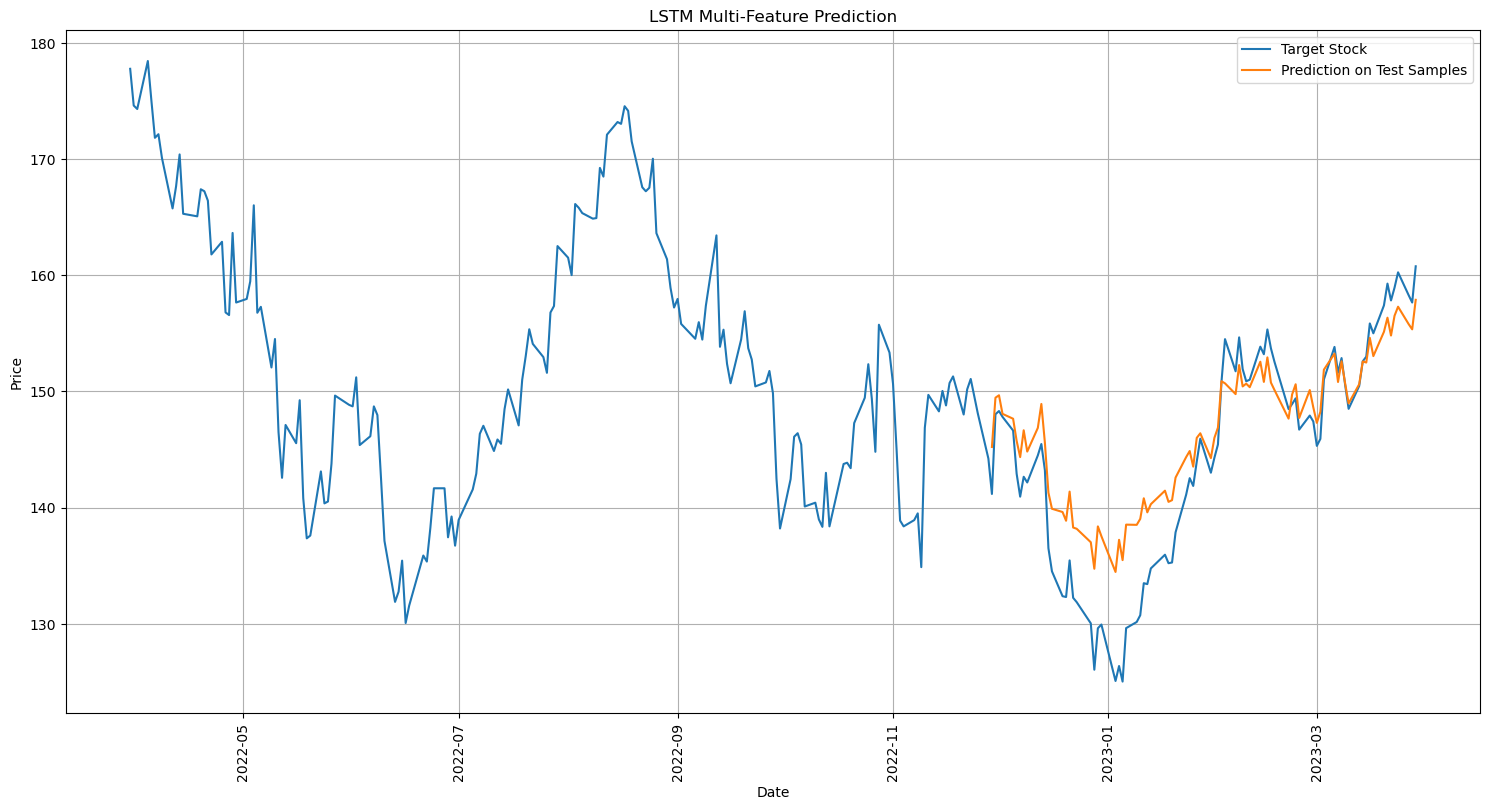

In [198]:
# shift train predictions for plotting
testPredictPlot_feature = np.empty_like(dataset);
testPredictPlot_feature[:, :] = np.nan;
inv_yhat = np.reshape(inv_yhat, (inv_yhat.shape[0], 1));
testPredictPlot_feature[-1*len(inv_yhat):, :] = inv_yhat;
# plot baseline and predictions where the baseline is the close price of target stock
plt.figure(figsize=(15,8));
plt.plot(df.index.values, df['Close'], label='Target Stock');
plt.plot(df.index.values, testPredictPlot_feature, label='Prediction on Test Samples');

plt.xlabel('Date');
plt.ylabel('Price');
plt.xticks(rotation=90);
plt.tight_layout();
plt.grid();
plt.title('LSTM Multi-Feature Prediction');
plt.legend(loc='best');
plt.show();

In [ ]:
#double test

In [ ]:
'''
# reshape into X=t and Y=t+1
look_back = 1;
trainX_feature = train_feature[:-1*look_back] #delete rows on the bottom;
trainY_feature = np.roll(train_feature, -1*look_back, axis=0)[:-1*look_back];
testX_feature = test_feature[:-1*look_back];
testY_feature = np.roll(test_feature, -1*look_back, axis=0)[:-1*look_back];
'''

In [ ]:
# invert predictions
trainPredict_feature = scaler.inverse_transform(trainPredict_feature);
trainY_feature = scaler.inverse_transform(trainY_feature);
testPredict_feature = scaler.inverse_transform(testPredict_feature);
testY_feature = scaler.inverse_transform(testY_feature);

In [ ]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict[:,0]));
print('Train Score: %.2f RMSE' % (trainScore));
testScore = np.sqrt(mean_squared_error(testY, testPredict[:,0]));
print('Test Score: %.2f RMSE' % (testScore));
